# Tutorial 3.1: Solving the dynamic motion of a rod using Finite Differences
In this tutorial you will learn how to solve the dynamic motion of a rod using Finite Differences. Here we will follow the example presented in the lectures.

Let's consider the EOM of a rod of length $L$:
$$ \rho A\ddot{u}-EAu{''}=q(x,t)\qquad\mbox{for }x\in[0,L], $$
with $\rho$ the density, $A$ the cross section area, $E$ the young modulus and $q$ an external (distributed) load.

The system is subject to boundary conditions:
- $u=0$ at $x=0$
- $EAu{'}=F(t)$ at $x=L$

### The roadmap to finde the beam deflection using Finite Differences
The steps needed to discretize the rod are listed next.

1. Discretize space into $N+1$ points.
2. Discretize the EOM of the rod. To do this, you will have to approximate the 2nd order derivative with FD. Use a second order approximation. You can find the coefficients here (or google `finite difference coefficients' and click the Wikipedia page)}.
3. Apply the boundary conditions. Use the definition of discrete derivatives and EOM to find the relation between the ghost points and the interior points.
4. Combine all equations into matrices.
5. Solve the resulting ODE system

Let's first install all required packages

In [1]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp

## Step 1: Discretize the domain

In [2]:
L = 10
N = 10
x = np.linspace(0,L,N+1)
print(x)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


### Step 2: Discretize the EOM of the rod

Using the coefficients for a centered FD scheme for 2nd order derivatives with 2nd order accuracy we have:

$$ u_i^{''} = \frac{u_{i-1}-2u_i+u_{i+1}}{\Delta x^2}$$

And for the 1st order derivative:

$$ u_i^{'} = \frac{-0.5u_{i-1}+0.5u_{i+1}}{\Delta x}$$

Replacing these expressions into the equation of motion we get the following discrete system:

$$ \rho A \ddot{u}_i - \frac{EA}{\Delta x^2}\left(u_{i-1}-2u_i+u_{i+1}\right) = q_i $$


### Step 3: Apply boundary conditions

At $x=0$ we have that $u(0)=0$, then 
$$ u_0 = 0 $$

Since we know the values of $u(0)$ for all times, we will not include them on the system. Using all this relation, we get the discrete equation for $i=1$ as:
$$ \rho A \ddot{u}_0 - \frac{EA}{\Delta x^2}\left(-2u_1+u_{2}\right) = q_1 $$

On the other side, we use the force relation
$$EA\ u{'}(L) = F(t) $$
$$EA\frac{-u_{N-1}+u_{N+1}}{2\Delta x} = F(t)$$
Thus
$$u_{N+1} = \frac{2\Delta x}{EA}F(t)+u_{N-1}$$

So, the discrete equations of motion for $i=N$ is:
$$  \rho A \ddot{u}_N - \frac{EA}{\Delta x^2}\left(2u_{N-1}-2u_N\right) = q_N+\frac{2}{\Delta x}F(t) $$


### Step 4: Matrix form

Summarizing we have the following discrete (in space) equations:

- For $i=1$:
$$ \rho A \ddot{u}_1 - \frac{EA}{\Delta x^2}\left(-2u_1+u_{2}\right) = q_1 $$
- For $i=2,...,N-1$:
$$ \rho A \ddot{u}_i - \frac{EA}{\Delta x^2}\left(u_{i-1}-2u_i+u_{i+1}\right) = q_i $$
- For $i=N$:
$$ \rho A \ddot{u}_N - \frac{EA}{\Delta x^2}\left(2u_{N-1}-2u_N\right) = q_N+\frac{2}{\Delta x}F(t) $$  

This is equivalent to the following system:
$$\rho A \left[\begin{matrix}
1&0&0&\ldots&0&0&0\\
0&1&0&\ldots&0&0&0\\
0&0&1&\ldots&0&0&0\\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots&\vdots\\
0&0&0&\ldots&1&0&0\\
0&0&0&\ldots&0&1&0\\
0&0&0&\ldots&0&0&1\\
\end{matrix}\right]\left[\begin{matrix}
\ddot{u}_1\\
\ddot{u}_2\\
\ddot{u}_3\\
\vdots\\
\ddot{u}_{N-2}\\
\ddot{u}_{N-1}\\
\ddot{u}_N\\
\end{matrix}\right]
- \frac{EA}{\Delta x^2} \left[\begin{matrix}
-2&1&0&0&0&&0&0&0\\
1&-2&1&0&0&\ldots&0&0&0\\
0&1&-2&1&0&&0&0&0\\
&&\vdots&&&\ddots&&\vdots&\\
0&0&0&&0&1&-2&1&0\\
0&0&0&\ldots&0&0&1&-2&1\\
0&0&0& &0&0&0&2&-2\\
\end{matrix}\right]\left[\begin{matrix}
u_1\\
u_2\\
u_3\\
\vdots\\
u_{N-2}\\
u_{N-1}\\
u_N\\
\end{matrix}\right] = \left[\begin{matrix}
q_1\\
q_2\\
q_3\\
\vdots\\
q_{N-2}\\
q_{N-1}\\
q_N + \frac{2}{\Delta x}F(t)\\
\end{matrix}\right]$$

And in a compact form:
$$\boldsymbol{M}\ddot{\boldsymbol{w}}-\boldsymbol{K}\boldsymbol{w}=\boldsymbol{F}$$

Now we can define the matrices:

In [3]:
# Construct the matrices
M = np.eye(N)
K = np.zeros((N,N))

## Define some parameters (no physical sense)
E = 2e7
A = np.pi*2*0.07
rho = 4000

## Define the force
def q(x,t):
    return 1e2*x*np.sin(3.0*t)
def F(t):
    return 1e4*np.sin(0.3*t)

# Fill in stiffness matrix
K[0,0] = -2;  K[0,1] = 1
K[N-1,N-2] = 2; K[N-1,N-1]=-2;
for i in range(1,N-1):
    K[i,range(i-1,i+2)] = [1, -2, 1]

# Apply scaling
dx = L/N
M = rho*A*M
K = E*A/(dx**2)*K

# Fill in force
def Fvec(t):
    Ft = np.zeros((N,))
    for i in range(0,N):
        xi = x[i+1]
        Ft[i] = q(xi,t)
    Ft[N-1] = Ft[N-1] + 2*F(t)/(dx)
    return Ft

# Step 5: Solve the ODE system

Now, we just need to apply what we learned in the previous modules to solve the dynamic problem. The main novelty is that here we work with matrices.

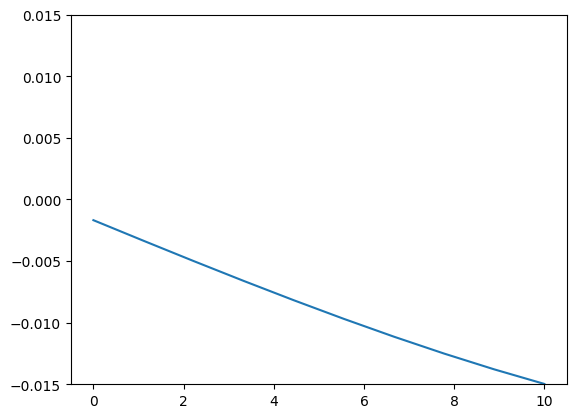

In [4]:
# Define the ODE function (given q, return dq)
def q_dot(t,q):
    displ = q[0:N]
    velos = q[N:2*N]
    accel = np.linalg.inv(M).dot((Fvec(t)+K.dot(displ)+0.1*K.dot(velos))) #0.1 is damping factor, can change
    dq = np.zeros((2*N,))
    dq[0:N] = velos
    dq[N:2*N] = accel
    return dq

# Define initial state
q0 = np.zeros(2*N)

# Define time interval and time evaluation points
t0 = 0
tf = 100.0
nt = 50
tspan = np.linspace(t0,tf,nt+1)

# Solve (we use Radau method because the ODE is very stiff and it works best for this case)
sol = solve_ivp(fun=q_dot,t_span=[t0,tf],y0=q0,t_eval=tspan,method='Radau')

# Plot
import time
import pylab as pl
from IPython import display
for i in range(0,len(tspan)):
    #fig,ax = plt.subplots()
    display.clear_output(wait=True)
    #display.display(pl.gcf())
    plt.plot(np.linspace(0,L,N),sol.y[0:N,i])
    plt.ylim((-0.015,0.015))
    time.sleep(0.05)
    plt.show()

## Exercise: Add friction to the system

Solve the same problem, but considering friction in the rod for $x<L/2$. In that case, the equation of motion reads:
$$ \rho A\ddot{u}-EAu{''}+k_f(x) u=q(x,t)\qquad\mbox{for }x\in[0,L], $$
with $k_f(x)=\begin{cases}k_0\qquad\mbox{if $x<L/2$}\\0\qquad\mbox{otherwise}\end{cases}$

Compare the solution using $k_0=1.0e8$ and $k_0=1.0e5$.

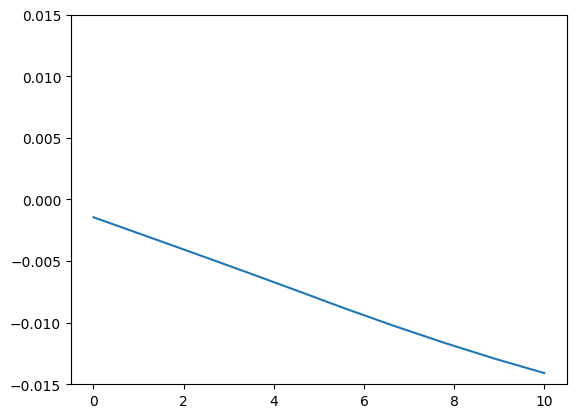

In [6]:
# Exrtra parameters
k_0 = 1.0e5
# Double-parameters not repeated

# Construct the matrices
M = np.eye(N)
K = np.zeros((N,N))
K0 = np.zeros((N,N))

# Fill in stiffness matrix
K[0,0] = -2;  K[0,1] = 1
K[N-1,N-2] = 2; K[N-1,N-1]=-2;
for i in range(1,N-1):
    K[i,range(i-1,i+2)] = [1, -2, 1]
for i in range(int(N/2)):
    K0[i,i] = 1

# Apply scaling
dx = L/N
M = rho*A*M
K = E*A/(dx**2)*K
K0 = k_0*K0

# Define the ODE function (given q, return dq)
def q_dot(t,q):
    displ = q[0:N]
    velos = q[N:2*N]
    #0.1 is damping factor, can change, below == semi-discrete equation
    accel = np.linalg.inv(M).dot((Fvec(t)+K.dot(displ)+0.1*K.dot(velos)-K0.dot(displ))) 
    dq = np.zeros((2*N,))
    dq[0:N] = velos
    dq[N:2*N] = accel
    return dq

# Solve (we use Radau method because the ODE is very stiff and it works best for this case)
sol = solve_ivp(fun=q_dot,t_span=[t0,tf],y0=q0,t_eval=tspan,method='Radau')

# Plot
for i in range(0,len(tspan)):
    #fig,ax = plt.subplots()
    display.clear_output(wait=True)
    #display.display(pl.gcf())
    plt.plot(np.linspace(0,L,N),sol.y[0:N,i])
    plt.ylim((-0.015,0.015))
    time.sleep(0.05)
    plt.show()